In this notebook we are going to use a simple Convolution neural net to classify a [FashionMNIST Dataset](https://www.kaggle.com/zalando-research/fashionmnist).

**Difference Between Convolutional Neural Network and Multilayer Perceptron?**
When we use MLP to classify MNIST we have flattened the 2D input image into a 1D tabular data. Doing this we are ignoring the rich structural information/spatial information a 2D image provide and are relying a bunch of flattened numbers only. Surely this is a limitation.

Say we have a gray-level image **H**x**W**, what we do in convolution is we take kernels or filters usually in shape 3x3 or 5x5 and convolve them with subimages of input image in the same shape as kernel. The outcome of each operation will be a point in output activation map. i.e we are convolving filters with image. If we look in depth, actually this can be considered as a same process we do in baby linear layer. The difference is instead of taking a very large input layer we are taking a sample of the input layer. The same filter is used throughout the image, the idea is if a filter learn something to do say detect eye, then it can be used throughout the image from top to bottom, from left to right. So what it does is allow us to use same filter at different position which means the total number of parameter will be very less compared MLP.

To solve FashionMNISt, we will use a simple CNN, it will have one convolution layer in which there will be 16 filters of size 3x3. Since there are 16 filters, the activation map from 1st convolution will have depth of 16. This activation map will be flattened and from here we will proceed as a MLP problem. We will use 100 neurons in next layer and 10 layers in output.


For more details on CNN:


[Convolutions and Backpropagations - Pavithra Solai](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c)

[Why do we rotate weights when computing the gradients in a convolution layer of a convolution network?](http://soumith.ch/ex/pages/2014/08/07/why-rotate-weights-convolution-gradient/)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)

[https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)

In [32]:
## Import necessary Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

In [33]:
## Read FashionMNIST Dataset
dataframe = pd.read_csv("fashion-mnist_train.csv")

## Just using 700 images
data = dataframe.values[:700]

## Split labels and images
labels = data[:, 0]
images = data[:, 1:]

## Normalize the image
images = images/255

## Splitting Training and Testing Set
train_test_split = 0.85
train_test_split_index = int(len(images) * train_test_split)
training_images = images[:train_test_split_index ]
testing_images = images[train_test_split_index: ]

## One-hot encoding the labels

one_hot_labels = []
for label in labels:
    base_label = np.zeros(10)
    base_label[int(label)] = 1
    one_hot_labels.append(base_label)

labels = np.array(one_hot_labels)
training_labels = labels[:train_test_split_index]
testing_labels = labels[train_test_split_index: ]

assert(len(training_images) == len(training_labels))
assert(len(testing_images) == len(testing_labels))

print(len(training_images))
print(len(testing_images))

595
105


In [34]:
## Labels name
index_to_label_name = {
    0: "t-shirt", 1: "trousers", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker",
    8: "bag", 9: "ankle boot"
}

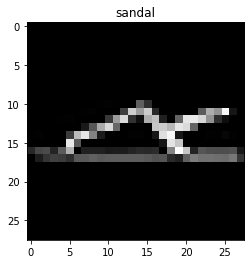

In [35]:
## Sample Training Image with label

img = training_images[7].reshape((28,28))
label = index_to_label_name[np.argmax(training_labels[7])]
plt.title(label)
plt.imshow(img, cmap="gray")

In [36]:
## Initialize weights

input_image_height = input_image_width = 28
input_image_depth = 1

kernel_1_width = kernel_1_height = 3
kernel_1_count = 16
kernel_1_depth = input_image_depth

kernel_1 = 0.2 * np.random.random((kernel_1_count , kernel_1_depth, kernel_1_height, kernel_1_width)) - 0.1

layer_1_output_size = input_image_height - kernel_1_height + 1

layer_2_size = 100

weight_layer_1_layer_2 = 0.2 * np.random.random(
    (kernel_1_count*layer_1_output_size*layer_1_output_size, layer_2_size)) - 0.1

output_size = 10
weight_layer_2_output = 0.2 * np.random.random((layer_2_size, output_size)) - 0.1

In [37]:
## Activation Function
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return (1 - output**2)

def softmax(x):
    temp = np.exp(x)
    return temp/np.sum(temp, axis=1, keepdims=True)

In [38]:
## Forward Convolution
## Takes input, kernel and returns output activation map
def convolution(input_tensor, kernel):
    kernel_height = kernel.shape[2]
    kernel_width = kernel.shape[3]
    output_tensor_height = input_tensor.shape[1] - kernel_height + 1
    output_tensor_width = input_tensor.shape[2] - kernel_width + 1
    
    output = list()
    
    for kernel_count_idx in range(kernel.shape[0]):
        select_kernel = kernel[kernel_count_idx]
        
        for row in range(output_tensor_height):
            for col in range(output_tensor_width):
                sum_kernel_sect = 0
                for didx in range(input_tensor.shape[0]):
                    sect = input_tensor[didx, row:row+kernel.shape[2], col:col+kernel.shape[3]]
            
                    sum_kernel_sect += np.sum(sect.dot(select_kernel[didx]))
                output.append(sum_kernel_sect)                 

    output = np.array(output)
    output = tanh(output)
    output = output.reshape((kernel.shape[0],output_tensor_height, output_tensor_width))
    
    
    
    return output             

In [39]:
## Calculates delta for the kernels
## Takes deltas, previous layer and kernel in-between and returns deltas for kernel
def weight_delta_convolution(input_tensor, delta_kernel_output, kernel):
    delta_kernel = np.empty_like(kernel)
    
    for delta_kernel_output_idx in range(delta_kernel_output.shape[0]):
        select_delta_kernel_output = delta_kernel_output[delta_kernel_output_idx]
        
        for row in range(input_tensor.shape[1] - select_delta_kernel_output.shape[0] + 1):
            for col in range(input_tensor.shape[2] - select_delta_kernel_output.shape[1] + 1):
                
                for input_tensor_idx in range(input_tensor.shape[0]):
                    sect = input_tensor[input_tensor_idx, row:row+select_delta_kernel_output.shape[0],
                                        col:col+select_delta_kernel_output.shape[1]]
                    delta_kernel[delta_kernel_output_idx, input_tensor_idx, row, col] = np.sum(
                        sect.dot(select_delta_kernel_output)
                    )
    return delta_kernel

In [40]:
num_iterations = 10
lr = 0.001
train_losses = list() ## For plotting train loss 
test_losses = list()

for itera in range(1, num_iterations+1):
    
    train_error = 0
    train_correct = 0
    
    for img_idx in range(len(training_images)):
        
        img = training_images[img_idx]
        label = training_labels[img_idx].reshape((10, 1))
        
        layer_0 = img.reshape((input_image_depth, input_image_height, input_image_width))
        
        layer_1 = convolution(layer_0, kernel_1)
        
        layer_1_flattened = layer_1.reshape((-1, 1))
        
        layer_2 = tanh(weight_layer_1_layer_2.T.dot(layer_1_flattened))
        
        final_output = weight_layer_2_output.T.dot(layer_2)
        ##.## Softmax
        train_error = train_error + np.sum((final_output - label)**2)
        train_correct = train_correct + int(np.argmax(final_output) == np.argmax(label))
        
        
        delta_final_output = final_output - label
        delta_layer_2 = weight_layer_2_output.dot(delta_final_output) * tanh2deriv(layer_2)
        delta_layer_1_flattened = weight_layer_1_layer_2.dot(delta_layer_2) * tanh2deriv(layer_1_flattened)
        
        weight_layer_2_output = weight_layer_2_output - lr * layer_2.dot(delta_final_output.T)
        weight_layer_1_layer_2 = weight_layer_1_layer_2 - lr * layer_1_flattened.dot(delta_layer_2.T)
        
#         kernel_1 = kernel_1 - lr * layer_0.dot(delta_layer_1_flattened)
        
        kernel_1 = kernel_1 - lr * weight_delta_convolution(
            layer_0, delta_layer_1_flattened.reshape(layer_1.shape), kernel_1
        )
        
    if itera % 1 == 0:
        ###
        ### Testing for every n times, n= 1,2,3...
        ###
        
        test_error = 0
        test_correct = 0

        for img_idx in range(len(testing_images)):

            img = testing_images[img_idx]
            label = testing_labels[img_idx].reshape((10, 1))

            layer_0 = img.reshape((input_image_depth, input_image_height, input_image_width))

            layer_1 = convolution(layer_0, kernel_1)

            layer_1_flattened = layer_1.reshape((-1, 1))

            layer_2 = tanh(weight_layer_1_layer_2.T.dot(layer_1_flattened))

            final_output = weight_layer_2_output.T.dot(layer_2)
#             final_output = softmax(final_output)
            ##.## Softmax
            test_error = test_error + np.sum((final_output - label)**2)
            test_correct = test_correct + int(np.argmax(final_output) == np.argmax(label))







        print("Itera: {} Train Error: {:4f} Accuracy: {:.4f}%".format(itera, 
                    train_error/len(training_images), (train_correct/len(training_images)) * 100))
        print("Itera: {} Test Error: {:4f} Accuracy: {:.4f}%".format(itera, 
                    test_error/len(testing_images), (test_correct/len(testing_images)) * 100))
    
    train_losses.append(train_error)
    test_losses.append(test_error)
        

Itera: 1 Train Error: 0.899918 Accuracy: 44.0336%
Itera: 1 Test Error: 0.627650 Accuracy: 57.1429%
Itera: 2 Train Error: 0.613205 Accuracy: 60.0000%
Itera: 2 Test Error: 0.549853 Accuracy: 67.6190%
Itera: 3 Train Error: 0.540253 Accuracy: 68.4034%
Itera: 3 Test Error: 0.509482 Accuracy: 69.5238%
Itera: 4 Train Error: 0.498734 Accuracy: 70.7563%
Itera: 4 Test Error: 0.485835 Accuracy: 71.4286%
Itera: 5 Train Error: 0.471612 Accuracy: 72.2689%
Itera: 5 Test Error: 0.472642 Accuracy: 70.4762%
Itera: 6 Train Error: 0.451889 Accuracy: 74.1176%
Itera: 6 Test Error: 0.464003 Accuracy: 71.4286%
Itera: 7 Train Error: 0.435645 Accuracy: 74.7899%
Itera: 7 Test Error: 0.454597 Accuracy: 71.4286%
Itera: 8 Train Error: 0.421434 Accuracy: 75.9664%
Itera: 8 Test Error: 0.444208 Accuracy: 71.4286%
Itera: 9 Train Error: 0.408714 Accuracy: 76.4706%
Itera: 9 Test Error: 0.433911 Accuracy: 73.3333%
Itera: 10 Train Error: 0.396849 Accuracy: 77.3109%
Itera: 10 Test Error: 0.423597 Accuracy: 73.3333%


Clearly there is something very wrong with testing and I am mad. #Attention

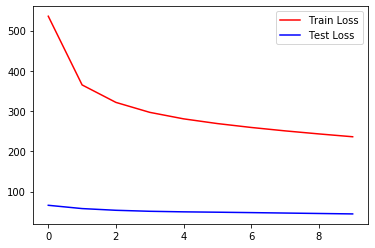

In [45]:
plt.plot(train_losses, "r", label="Train Loss")
plt.plot(test_losses, "b", label="Test Loss")
plt.legend()

Clearly, Our model is not generalized well. We may try with using dropout, larger trainsets, mini-batches to generalize our model well.

In [46]:
def predict(img_idx):
        img = testing_images[img_idx]
        label = testing_labels[img_idx].reshape((10, 1))
        
        layer_0 = img.reshape((input_image_depth, input_image_height, input_image_width))
        
        layer_1 = convolution(layer_0, kernel_1)
        
        layer_1_flattened = layer_1.reshape((-1, 1))
        
        layer_2 = tanh(weight_layer_1_layer_2.T.dot(layer_1_flattened))
        
        final_output = weight_layer_2_output.T.dot(layer_2)
        final_outut = softmax(final_output)
        plt.title("Actual: {} Predicted: {}".format(index_to_label_name[np.argmax(label)], index_to_label_name[np.argmax(final_output)]))
        plt.imshow(img.reshape((28,28)), cmap="gray")
    

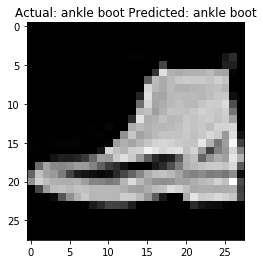

In [47]:
predict(img_idx = 20)

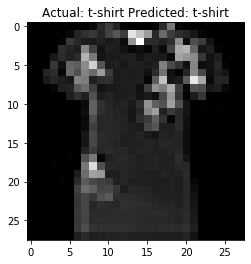

In [49]:
predict(img_idx = 19)

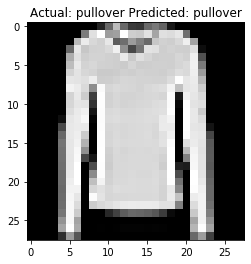

In [51]:
predict(img_idx = 98)

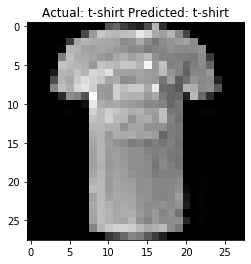

In [52]:
predict(img_idx = 23)

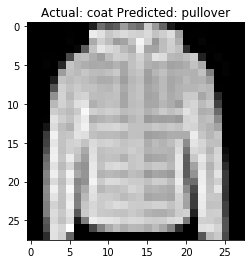

In [53]:
predict(img_idx = 88)